In [3]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from keras import Input, layers, Model, models
from keras.applications import *
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report, f1_score, top_k_accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
!pip3 install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.2 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount("/content/drive")

!unzip "/content/drive/MyDrive/Pokedex/data.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/Pidgeotto/RB_017_front.png  
 extracting: /content/data/Pidgeotto/RS_017_front.png  
  inflating: /content/data/Pidgeotto/Shiny_Pidgeotto_BW.png  
  inflating: /content/data/Pidgeotto/Shiny_Pidgeotto_BW_Back.png  
 extracting: /content/data/Pidgeotto/S_017_front.png  
 extracting: /content/data/Pidgeotto/Y_017_front.png  
  inflating: /content/data/Pidgeot/0062468234d74584ae2603c7b2159830.jpg  
 extracting: /content/data/Pidgeot/018.png  
 extracting: /content/data/Pidgeot/018M.png  
  inflating: /content/data/Pidgeot/018Pidgeot-Mega_XY_anime.png  
  inflating: /content/data/Pidgeot/018Pidgeot_AG_anime.png  
  inflating: /content/data/Pidgeot/018Pidgeot_Dream.png  
  inflating: /content/data/Pidgeot/018Pidgeot_Masters.png  
  inflating: /content/data/Pidgeot/018Pidgeot_Mega_Dream.png  
 extracting: /content/data/Pidgeot/018Pidgeot_Mega_Masters.png  
  inflating: /content/data/Pidgeot/018Pidgeot_Mega_PokВmon_H

#### Dataset

In [5]:
DATA_DIR_NAME = 'data'

In [6]:
class_names = os.listdir(DATA_DIR_NAME)
class_names.sort()
num_classes = len(class_names)
class_names[:10]

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur']

In [7]:
image_paths = []
labels = []
for class_name in class_names:
    pokemon_dir = os.path.join(DATA_DIR_NAME, class_name)
    image_file_names = os.listdir(pokemon_dir)
    image_paths.extend(os.path.join(pokemon_dir, name) for name in image_file_names)
    labels.extend([class_name] * len(image_file_names))

df = pd.DataFrame({'filename': image_paths, 'class': labels})

In [8]:
df.value_counts('class')

class
Pikachu      286
Charizard    167
Venusaur     162
Sandslash    142
Gengar       140
            ... 
Poliwrath     61
Nidoking      60
Dratini       57
Nidoran♂      50
Nidoran♀      44
Length: 151, dtype: int64

In [9]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df['class']  # Ensure all pokemon represented in each split
)
train_df, validation_df = train_test_split(
    train_df,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=train_df['class']
)

In [10]:
# Display images in a grid format
def display_images(image_paths, captions, image_size, cols, figsize=(8, 8)):
    rows = (len(image_paths) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = axs.ravel()
    for ax in axs:
        ax.axis('off')
    for ax, image_path, caption in zip(axs, image_paths, captions):
        image = load_img(image_path, target_size=image_size)
        ax.set_title(caption)
        ax.imshow(image)

    plt.show()

### Utilities

In [32]:
def make_image_generator(dataframe, image_size, preprocessing_function, batch_size=64, shuffle=True, **augmentations):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        **augmentations
    )
    return datagen.flow_from_dataframe(
        dataframe,
        target_size=image_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=shuffle
    )

In [14]:
def make_training_generators(image_size, preprocessing_function, batch_size=64, **augmentations):
    train_generator = make_image_generator(train_df, image_size, preprocessing_function, batch_size, **augmentations)
    validation_generator = make_image_generator(validation_df, image_size, preprocessing_function, batch_size)
    return train_generator, validation_generator

In [15]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Baseline Model

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input
)

In [ ]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base_model.trainable = False

vgg16_model = models.Sequential([
  vgg16_base_model,
  layers.Flatten(input_shape=vgg16_base_model.output_shape[1:]),
  layers.Dense(4096, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

vgg16_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

In [ ]:
# vgg16_model.save('models/vgg16_model.tf')
vgg16_model.save('/content/drive/MyDrive/Pokedex/models/model_vgg16.tf')
with open('/content/drive/MyDrive/Pokedex/histories/model_vgg16.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)

### Models

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=resnet.preprocess_input
)

resnet_base_model = ResNet152(weights='imagenet', include_top=False)
resnet_base_model.trainable = False

resnet_model = models.Sequential([
  resnet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_v3.preprocess_input
)

inception_v3_base_model = InceptionV3(weights='imagenet', include_top=False)
inception_v3_base_model.trainable = False

inception_v3_model = models.Sequential([
  inception_v3_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

inception_v3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_v3_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(299, 299),
    preprocessing_function=inception_resnet_v2.preprocess_input
)

inception_resnet_base_model = InceptionResNetV2(weights='imagenet', include_top=False)
inception_resnet_base_model.trainable = False

inception_resnet_model = models.Sequential([
  inception_resnet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

inception_resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
inception_resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
  densenet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=efficientnet.preprocess_input
)

efficientnet_base_model = EfficientNetB7(weights='imagenet', include_top=False)
efficientnet_base_model.trainable = False

efficientnet_model = models.Sequential([
  efficientnet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping]
)

### Data Augmentation

In [ ]:
# Without data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
  densenet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


<Axes: title={'center': 'Image counts for selected Pokémon before augmentation'}, xlabel='Pokémon', ylabel='Sample Count'>

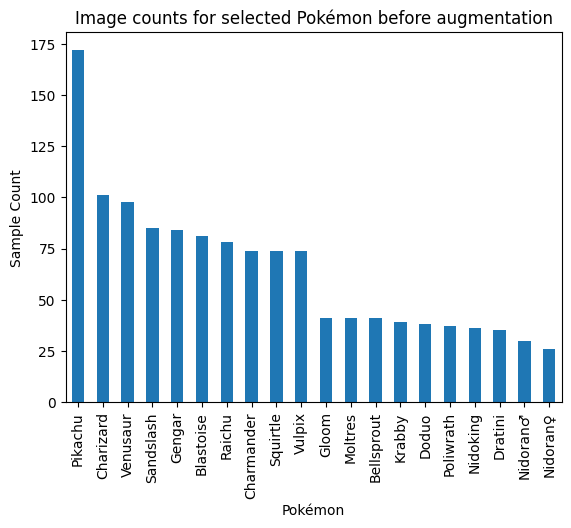

In [ ]:
highest_counts = train_df.value_counts("class")[:10]
lowest_counts = train_df.value_counts("class")[-10:]
(pd.concat([highest_counts, lowest_counts])).plot(kind="bar", xlabel="Pokémon", ylabel="Sample Count", title="Image counts for selected Pokémon before augmentation")

In [ ]:
hist1 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping]
)

In [ ]:
train_size = len(train_generator) * 64
epochs = 20

<Axes: title={'center': 'Rough image counts for selected Pokémon after augmentation'}, xlabel='Pokémon', ylabel='Sample Count'>

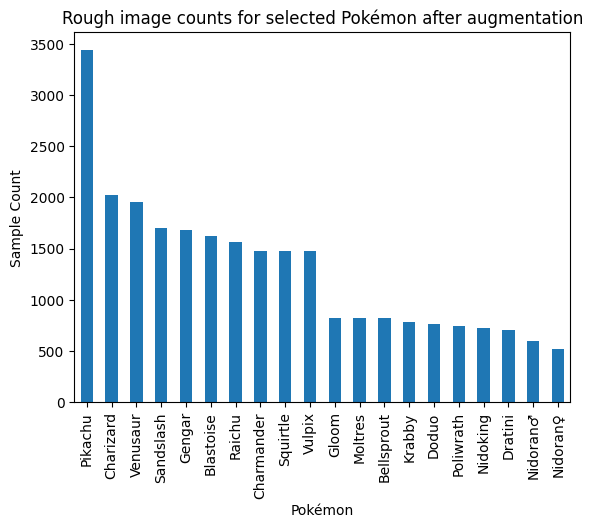

In [ ]:
highest_counts = (train_df.value_counts("class") * epochs)[:10] #data is augmented with each epoch
lowest_counts = (train_df.value_counts("class") * epochs)[-10:]
(pd.concat([highest_counts, lowest_counts])).plot(kind="bar", xlabel="Pokémon", ylabel="Sample Count", title="Rough image counts for selected Pokémon after augmentation")

In [ ]:
# With data augmentations
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    brightness_range = (0.8, 1.2),
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

densenet_model = models.Sequential([
  densenet_base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dense(num_classes, activation='softmax')
])

densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
hist2 = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    steps_per_epoch=train_size / 64
)

Epoch 1/20
 76/130 [================>.............] - ETA: 4:55 - loss: 4.5225 - accuracy: 0.1099

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(hist1.history['loss'], label='Training Loss (Without Data Augmentation)', color='blue')
plt.plot(hist1.history['val_loss'], label='Validation Loss (Without Data Augmentation)', color='cyan')
plt.plot(hist2.history['loss'], label='Training Loss (With Data Augmentation)', color='red')
plt.plot(hist2.history['val_loss'], label='Validation Loss (With Data Augmentation)', color='pink')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Hyperparameter Tuning

In [ ]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range = (0.8, 1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.
74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
train_size = len(train_generator) * 64

def build_model(hp):
    dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5])
    model = models.Sequential()
    model.add(densenet_base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(dropout))
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(layers.Dense(1024 // (2 ** i), activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

In [ ]:
#### HYPERPARAMETER TUNING #####
tuner = kt.tuners.GridSearch(
    build_model,
    objective='val_accuracy',
    directory='/content/drive/MyDrive/Pokedex/tuner',
    project_name='pokedex'
)

tuner.search_space_summary()

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping],
    steps_per_epoch=train_size / 64
)

tuner.results_summary()

Reloading Tuner from /content/drive/MyDrive/Pokedex/tuner/pokedex/tuner0.json
Search space summary
Default search space size: 2
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
Results summary
Results in /content/drive/MyDrive/Pokedex/tuner/pokedex
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
dropout: 0.25
num_layers: 0
Score: 0.8148943781852722

Trial 0000 summary
Hyperparameters:
dropout: 0.0
num_layers: 0
Score: 0.8088077306747437

Trial 0006 summary
Hyperparameters:
dropout: 0.5
num_layers: 0
Score: 0.7973505258560181

Trial 0004 summary
Hyperparameters:
dropout: 0.25
num_layers: 1
Score: 0.795918345451355

Trial 0001 summary
Hyperparameters:
dropout: 0.0
num_layers: 1
Score: 0.7780164480209351

Trial 0005 summary
Hyperparameters:
dropout: 0.25
num_layers: 

### Experiment with Layer Unfreezing

In [20]:
train_generator, validation_generator = make_training_generators(
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    brightness_range = (0.8, 1.2),
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 8379 validated image filenames belonging to 151 classes.
Found 2793 validated image filenames belonging to 151 classes.


In [ ]:
densenet_base_model = DenseNet201(weights='imagenet', include_top=False)
densenet_base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = densenet_base_model(inputs, training=False)  # Ensure batchnorm layers run in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_train = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

In [ ]:
model.save('models/model_untuned.tf')
with open('histories/model_training.pkl', 'wb') as file:
    pickle.dump(history_train.history, file)

In [ ]:
temp = DenseNet201(weights=None, include_top=False)

In [ ]:
for i, layer in enumerate(temp.layers):
    print(i, layer.name)

In [21]:
NUM_LAYERS_TO_UNFREEZE = 100

model = models.load_model('/content/drive/MyDrive/Pokedex/models/model_untuned.tf')

# Unfreeze layers in conv5
for layer in model.get_layer('densenet201').layers[-NUM_LAYERS_TO_UNFREEZE:]:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-5),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
131/131 [==============================] - 229s 2s/step - loss: 0.3403 - accuracy: 0.9163 - val_loss: 0.7185 - val_accuracy: 0.8185
Epoch 2/30
131/131 [==============================] - 200s 2s/step - loss: 0.3391 - accuracy: 0.9173 - val_loss: 0.7104 - val_accuracy: 0.8213
Epoch 3/30
131/131 [==============================] - 199s 2s/step - loss: 0.3291 - accuracy: 0.9187 - val_loss: 0.7050 - val_accuracy: 0.8228
Epoch 4/30
131/131 [==============================] - 203s 2s/step - loss: 0.3257 - accuracy: 0.9198 - val_loss: 0.7022 - val_accuracy: 0.8246
Epoch 5/30
131/131 [==============================] - 201s 2s/step - loss: 0.3259 - accuracy: 0.9235 - val_loss: 0.7002 - val_accuracy: 0.8238
Epoch 6/30
131/131 [==============================] - 199s 2s/step - loss: 0.3173 - accuracy: 0.9208 - val_loss: 0.6992 - val_accuracy: 0.8249
Epoch 7/30
131/131 [==============================] - 202s 2s/step - loss: 0.3287 - accuracy: 0.9193 - val_loss: 0.6982 - val_accuracy: 0.8256

In [22]:
model.save('/content/drive/MyDrive/Pokedex/models/model_final.tf')

FileNotFoundError: ignored

In [23]:
with open('/content/drive/MyDrive/Pokedex/histories/model_tuning.pkl', 'wb') as file:
    pickle.dump(history_fine.history, file)

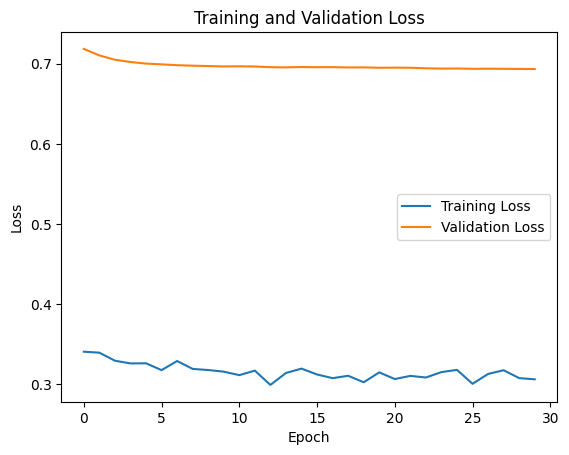

In [24]:
plt.figure()
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

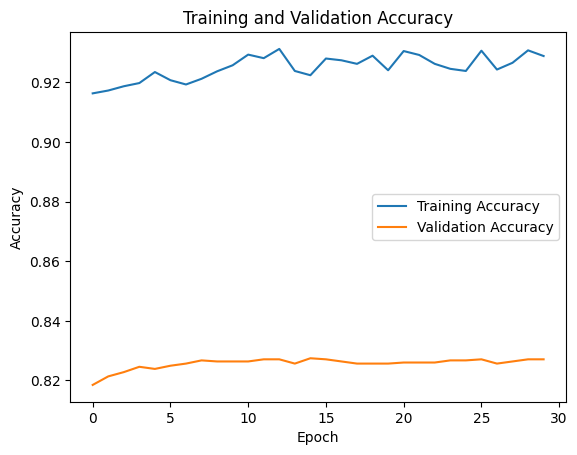

In [25]:
plt.figure()
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Testing

In [ ]:
baseline_model = models.load_model('/content/drive/MyDrive/Pokedex/models/model_baseline.tf')
final_model = models.load_model('/content/drive/MyDrive/Pokedex/models/model_final.tf')

In [ ]:
baseline_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=vgg16.preprocess_input,
    shuffle=False
)
final_model_test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    shuffle=False
)

In [ ]:
baseline_model_loss, baseline_model_acc = baseline_model.evaluate(baseline_model_test_generator)
final_model_loss, final_model_acc = final_model.evaluate(final_model_test_generator)

print(f'Baseline model loss:{baseline_model_loss:.5f}, Baseline model accuracy: {100 * baseline_model_acc:.3f}%')
print(f'Final model loss: {final_model_loss:.5f}, Final model accuracy: {100 * final_model_acc:.3f}%')

In [ ]:
baseline_model_probs = baseline_model.predict(baseline_model_test_generator)
final_model_probs = final_model.predict(final_model_test_generator)
actual_labels = final_model_test_generator.classes

k = 3
baseline_model_k_acc = top_k_accuracy_score(actual_labels, baseline_model_probs, k=k)
final_model_k_acc = top_k_accuracy_score(actual_labels, final_model_probs, k=k)

print(f'Baseline model top-{k} accuracy: {100 * baseline_model_k_acc:.3f}%')
print(f'Final model top-{k} accuracy: {100 * final_model_k_acc:.3f}%')

In [ ]:
baseline_pred_labels = np.argmax(baseline_model_probs, axis=-1)
final_pred_labels = np.argmax(final_model_probs, axis=-1)

# Use weighted average to account for class imbalance
baseline_model_f1 = f1_score(actual_labels, baseline_pred_labels, average='weighted')
final_model_f1 = f1_score(actual_labels, final_pred_labels, average='weighted')

print(f'Baseline model weighted average f1 score: {baseline_model_f1:.5f}')
print(f'Final model weighted average f1 score: {final_model_f1:.5f}')

In [ ]:
print(classification_report(actual_labels, final_pred_labels, target_names=class_names))

In [ ]:
conf_matrix = confusion_matrix(actual_labels, final_pred_labels)
sns.heatmap(conf_matrix, cmap='Blues')
plt.show()

In [ ]:
most_common_misclassifications = []

for r, row in enumerate(conf_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:20]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")

In [ ]:
misclassified_image_idxs = [idx for idx, (pred, actual) in enumerate(zip(final_pred_labels, actual_labels)) if pred != actual]
misclassified_images = test_df.iloc[misclassified_image_idxs]
captions = [
    f'Pred: {class_names[final_pred_labels[idx]]}\nActual: {class_names[actual_labels[idx]]}'
    for idx in misclassified_image_idxs
]
display_images(misclassified_images['filename'][:16], captions[:16], (224, 224), 4, figsize=(8, 9))

### Testing (old)

In [11]:
test_model = models.load_model('/content/drive/MyDrive/Pokedex/models/model_final.tf')

In [33]:
test_generator = make_image_generator(
    test_df,
    image_size=(224, 224),
    preprocessing_function=densenet.preprocess_input,
    shuffle=False
)

Found 2793 validated image filenames belonging to 151 classes.


In [34]:
test_model_loss, test_model_acc = test_model.evaluate(test_generator)

print(f'Final model loss: {test_model_loss:.5f}, Final model accuracy: {100 * test_model_acc:.3f}%')

44/44 [==============================] - 29s 660ms/step - loss: 0.6925 - accuracy: 0.8217
Final model loss: 0.69245, Final model accuracy: 82.170%


In [35]:
test_model_probs = test_model.predict(test_generator)
actual_labels = test_generator.classes

k = 3
test_model_k_acc = top_k_accuracy_score(actual_labels, test_model_probs, k=k)

print(f'Baseline model top-{k} accuracy: {100 * test_model_k_acc:.3f}%')
print(f'Final model top-{k} accuracy: {100 * test_model_k_acc:.3f}%')

44/44 [==============================] - 27s 623ms/step
Baseline model top-3 accuracy: 91.515%
Final model top-3 accuracy: 91.515%


In [36]:
test_pred_labels = np.argmax(test_model_probs, axis=-1)

# Use weighted average to account for class imbalance
test_model_f1 = f1_score(actual_labels, test_pred_labels, average='weighted')

print(f'Baseline model weighted average f1 score: {test_model_f1:.5f}')

Baseline model weighted average f1 score: 0.82133


In [37]:
print(classification_report(actual_labels, test_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

        Abra       0.92      0.79      0.85        14
  Aerodactyl       0.84      0.80      0.82        20
    Alakazam       0.78      0.78      0.78        18
       Arbok       0.83      0.83      0.83        18
    Arcanine       0.68      0.79      0.73        19
    Articuno       1.00      0.58      0.73        19
    Beedrill       0.84      0.89      0.86        18
  Bellsprout       0.86      0.86      0.86        14
   Blastoise       0.91      0.74      0.82        27
   Bulbasaur       0.85      1.00      0.92        23
  Butterfree       1.00      0.82      0.90        22
    Caterpie       1.00      0.83      0.91        18
     Chansey       0.89      0.89      0.89        19
   Charizard       0.64      0.85      0.73        33
  Charmander       0.74      0.96      0.84        24
  Charmeleon       0.87      0.62      0.72        21
    Clefable       0.86      1.00      0.92        18
    Clefairy       0.79    

In [40]:
conf_matrix = confusion_matrix(actual_labels, test_pred_labels)
# sns.heatmap(conf_matrix, cmap='Blues')
# plt.show()

In [41]:
most_common_misclassifications = []

for r, row in enumerate(conf_matrix):
    for c, val in enumerate(row):
        if r != c and val > 0:
            most_common_misclassifications.append((val, r, c))

most_common_misclassifications.sort(reverse=True)

print("Top Misclassifications:")
for count, actual, pred in most_common_misclassifications[:20]:
    print(f"True class {class_names[actual]} misclassified as {class_names[pred]}: Count {count}")

Top Misclassifications:
True class Machoke misclassified as Machamp: Count 5
True class Pidgeot misclassified as Pidgey: Count 4
True class Cubone misclassified as Marowak: Count 4
True class Charmeleon misclassified as Charizard: Count 4
True class Articuno misclassified as Dragonair: Count 4
True class Weezing misclassified as Koffing: Count 3
True class Pidgeotto misclassified as Pidgeot: Count 3
True class Nidorina misclassified as Nidorino: Count 3
True class Nidoking misclassified as Nidorino: Count 3
True class Krabby misclassified as Kingler: Count 3
True class Kadabra misclassified as Alakazam: Count 3
True class Growlithe misclassified as Arcanine: Count 3
True class Grimer misclassified as Muk: Count 3
True class Diglett misclassified as Dugtrio: Count 3
True class Charmeleon misclassified as Charmander: Count 3
True class Zubat misclassified as Golduck: Count 2
True class Zubat misclassified as Golbat: Count 2
True class Wigglytuff misclassified as Raichu: Count 2
True clas

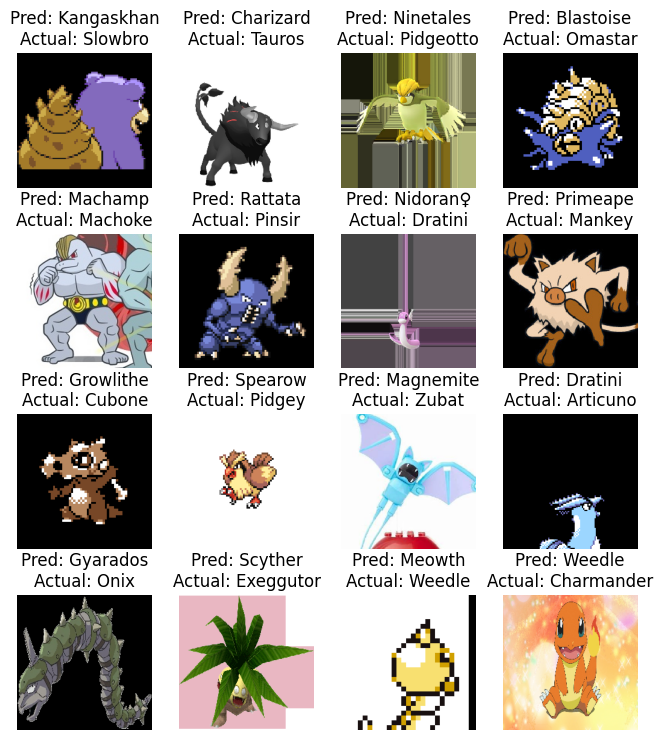

In [42]:
misclassified_image_idxs = [idx for idx, (pred, actual) in enumerate(zip(test_pred_labels, actual_labels)) if pred != actual]
misclassified_images = test_df.iloc[misclassified_image_idxs]
captions = [
    f'Pred: {class_names[test_pred_labels[idx]]}\nActual: {class_names[actual_labels[idx]]}'
    for idx in misclassified_image_idxs
]
display_images(misclassified_images['filename'][:16], captions[:16], (224, 224), 4, figsize=(8, 9))